# Inversion of a sphere based on gravity response

This is a simple example for the probabilistic inversion of a classical geophysical example: the inversion of a sphere in the subsurface with a different density to the environment based on observed gravity data.

We start with the simplest possible case of only one observation (directly above the sphere) and only depth as an uncertain variable and then make the model progressively more complex.

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

import seaborn as sns
import pandas as pd
%matplotlib inline

tf.reset_default_graph()

# np.random.seed(111)
# tf.set_random_seed(111)


We now calculate the effect of this density contrast that would be observed on the surface. This is a well-studied example with an analytical solution:

$$g(x) = 10^5 \;\frac{4}{3} \,\pi \;\frac{r^3 \,\Delta \rho\, G\, z}
{\sqrt{\left( x^2 + z^2\right)^3}}$$

where:

- $z$ is the vertical position of the center of the sphere (lateral position at origin),
- $r$ its radius,
- $\Delta \rho$ the density difference to the surrounding domain,
- $G$ the gravitational constant,
- and $x$ the position at which the gravitational acceleration is calculated.


In [2]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


## Geometric model

We consider here a sphere in the subsurface with a different density. 

spherical point mass

In [59]:
#True model

sphere_center_true = 300. #m 
density_difference_true = 500. # kg/m^3: density diffrence to surrounding domain
sphere_radius_true = 100. #m

truevalue_list = [sphere_center_true,density_difference_true,sphere_radius_true]
x_domain=np.linspace(-1000,1000,101) #m

In [4]:
x_obs = np.linspace(-250, 250, 11)
grav_all = grav_analytical(x_domain, sphere_center_true, sphere_radius_true, density_difference_true)
grav_obs_array = grav_analytical(x_obs, sphere_center_true, sphere_radius_true, density_difference_true)
noise = norm(0,0.01).rvs(len(grav_obs_array))
grav_obs_array_withnoise = grav_obs_array +noise

Calculate the variance of the noise, put the variance in an noise tensor

In [5]:
noise_variance = np.std(noise)

noise_1 = tf.convert_to_tensor([noise_variance],dtype = tf.float32)
eye = tf.eye(x_obs.shape[0])
noise_tensor = tf.multiply(noise_1,eye)

Text(0, 0.5, 'Y [m]')

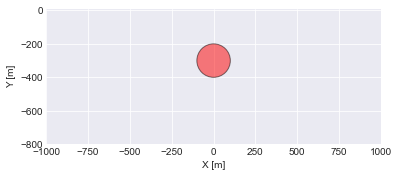

In [6]:
plt.style.use('seaborn-darkgrid')
ax = plt.subplot(aspect='equal') 

# create circle object as matplotlib patch
circle1 = plt.Circle((0, -sphere_center_true), sphere_radius_true, 
                     facecolor='r', edgecolor='k', alpha=0.5)

ax.add_artist(circle1)

# set model domain
ax.set_xlim([-1000,1000])
ax.set_ylim([-800,10])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")


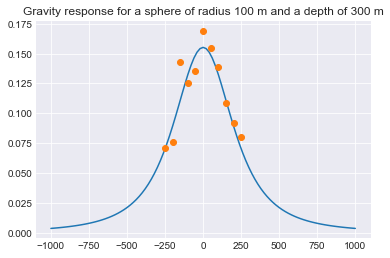

In [7]:
plt.plot(x_domain, grav_all)
plt.plot(x_obs, grav_obs_array_withnoise, 'o', label="data")
plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m");

### Algorithm Flowing hIPPYlib MCMC http://g2s3.com/labs/notebooks/SubsurfaceBayesian.html

Bayes’s Theorem

\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \pi_{\mathrm{like}}\left(\mathbf{d}_{\mathrm{obs}} | \mathrm{m}\right) \mathrm{d} \mu_{\mathrm{prior}}(\mathrm{m})
\end{equation}

Define the Prior
\begin{equation}
\mu_{\text {prior }} \sim \mathcal{N}\left(m_{\text {prior }}, C_{\text {prior }}\right)
\end{equation}

In [8]:
# sphere_center, density_difference, sphere_radius

mu_prior = [280., 480., 80.]


cov = [[ 30,  0.,  0.],
        [ 0.,  50, 0.],
        [ 0., 0.,  10]]


In [53]:
xvals =[]
norm_list =[]

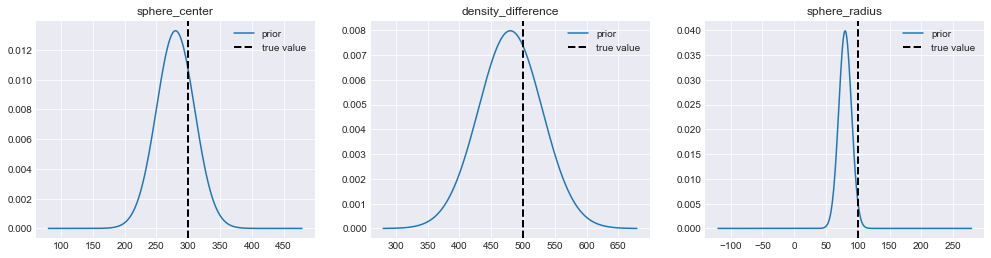

In [69]:
for i in range(3):
    xvals.append(np.arange(mu_prior[i]-200,mu_prior[i]+200))
    norm_list.append(norm.pdf(xvals[i],mu_prior[i],cov[i][i]))
    
np.shape(xvals)

name_list = ["sphere_center", "density_difference", "sphere_radius"]

fig, axes = plt.subplots(1, 3, sharex='col', sharey='col')
fig.set_size_inches(17, 4)


for i in range(3):
    
    axes[i].plot(xvals[i], norm_list[i],label="prior")
    axes[i].title.set_text(name_list[i])
    axes[i].axvline(truevalue_list[i], label="true value", color='k', 
            linestyle='--', linewidth=2)
    axes[i].legend();

    

Define the Likelihood
\begin{equation}
\mathbf{d}_{\mathrm{obs}}=\mathbf{f}(\mathrm{m})+\mathbf{e}, \quad \mathbf{e} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{\Gamma}_{\mathrm{noise}}\right)
\end{equation}
\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

In [74]:
mu_prior = tf.convert_to_tensor(mu_prior)
cov = tf.convert_to_tensor(cov)


In [75]:
# Defind f(m). Here f is the parameter-to-observable map that takes a 
# parameter m and maps it to the space observation vector dobs.

def grav_analytical_tf(x, mu, cov,sess):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
               * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 
    
    print(sess.run(mvn))
    

    return gravity



### Gradient decent to find MAP (?)

In [76]:
## function compute G^T C^-1 G

def matrixcompute(matrix1,matrix2,Cov):
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

#### The posterior


\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}

#### negative log of the posterior
\begin{equation}
\left(\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}


term 1 = 
\begin{equation}
\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}
\end{equation}

term 2 =
\begin{equation}
\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}
\end{equation}


In [78]:
def grav_analytical_tf(x, mu, cov,sess):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
               * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 
    
    print(sess.run(mvn))
    
    return gravity

In [77]:
#     print(sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)))

## initial guess

mu = tf.get_variable("mu", dtype=tf.float32,
  initializer=tf.constant([200., 400., 50.]))


In [79]:
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    grav = grav_analytical_tf(x_obs,mu, cov, session)
    term_1 = matrixcompute(grav,grav_obs_array_withnoise,noise_tensor)
    term_2 = matrixcompute(mu,mu_prior,cov)
    Negtive_log_likelihood = tf.add(term_1,term_2)
    
    
    optimizer = tf.train.GradientDescentOptimizer(0.5)
    train = optimizer.minimize(Negtive_log_likelihood,var_list =mu)
    log_tem = session.run(Negtive_log_likelihood) 
    
    
    print("starting at", "mu:", session.run(mu), "negative log likelihood:", session.run(Negtive_log_likelihood))
    for step in range(1000):  
        session.run(train)
        if step%100 == 0:print(session.run(tf.gradients(Negtive_log_likelihood,mu)))
        log_tem_new = session.run(Negtive_log_likelihood)
       ## Find and save MAP point 
        if log_tem_new < log_tem:
            log_tem = log_tem_new
            MAP = session.run(mu)
        
        if step%100 == 0: print("step", step, "mu:", session.run(mu), "negative log likelihood:",log_tem_new )

    

W0927 00:41:26.857061 4549256640 deprecation.py:323] From /Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[193.97017 397.26865  43.25671]
starting at mu: [200. 400.  50.] negative log likelihood: [[220.2573]]
[array([-2.6106827, -1.5880743, -2.9489505], dtype=float32)]
step 0 mu: [201.32545 400.80264  51.56267] negative log likelihood: [[210.41136]]
[array([-0.48547316, -0.5819642 , -0.01478148], dtype=float32)]
step 100 mu: [264.89734 451.23264  80.97894] negative log likelihood: [[12.60806]]
[array([-0.08959931, -0.2135685 , -0.01030522], dtype=float32)]
step 200 mu: [276.75085 469.6834   81.13444] negative log likelihood: [[2.536009]]
[array([-0.01628123, -0.07804206, -0.00949323], dtype=float32)]
step 300 mu: [278.95825 476.43347  81.15986] negative log likelihood: [[1.9550933]]
[array([-0.00357961, -0.02831864,  0.00457472], dtype=float32)]
step 400 mu: [279.3713  478.90244  81.14269] negative log likelihood: [[0.9850801]]
[array([ 6.0722232e-07, -1.0740235e-02, -7.3253289e-03], dtype=float32)]
step 500 mu: [279.45062  479.8048    81.140976] negative log likelihood: [[1.6343739]]
[arr

### <span style="color:red">Gradient decsent doesb't work well with this Problem</span>     Maybe fine?

It seems been track at the local minimum.   
Potential Solution:
* Globalized Newtown-CG method as in hIPPYlib

## pCN MCMC

In [80]:
# MAP = [300., 500., 100.]
MAP = tf.convert_to_tensor(MAP)

with tf.Session() as sess:

    print(sess.run(MAP))


[279.4635  480.23856  81.16916]


In [81]:
def compute_hessian(fn, vars):
    mat = []
    for v1 in vars:
        temp = []
        for v2 in vars:
            # computing derivative twice, first w.r.t v2 and then w.r.t v1
            temp.append(tf.gradients(tf.gradients(fn, v2)[0], v1)[0])
        temp = [cons(0) if t == None else t for t in temp] # tensorflow returns None when there is no gradient, so we replace None with 0
        temp = tf.stack(temp)
        mat.append(temp)
    mat = tf.stack(mat)
    return mat
def cons(x):
    return tf.constant(x, dtype=tf.float32)

### Forward model in TensorFlow

* Calculate Hessian
* Variable defined in Edward multivariate Normal object

In [82]:
def grav_analytical_tf(x, mu, cov, hess = False):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
           * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 

    if hess == True:
        hess = compute_hessian(gravity,[sphere_center,density_difference,sphere_radius])
        return gravity, hess
    return gravity


#### Compute the Hessian and Covariance of the Posterior at MAP

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [87]:
grav, hess = grav_analytical_tf(x_obs, MAP, cov, hess = True)


In [85]:
Matrix_tem = tf.add(hess, tf.linalg.inv(cov))

C_post = tf.linalg.inv(Matrix_tem)

In [86]:
with tf.Session() as session:
    print('hessian matrix at MAP: \n', session.run(hess))
    print('Covariance of the Prior: \n',session.run(cov))
    print('Covariance of the Posterior: \n',session.run(C_post))

hessian matrix at MAP: 
 [[ 2.5522539e-05 -6.8537452e-06 -1.2813433e-04]
 [-6.8537447e-06  0.0000000e+00  4.9614689e-05]
 [-1.2813434e-04  4.9614689e-05  6.1838177e-04]]
Covariance of the Prior: 
 [[30.  0.  0.]
 [ 0. 50.  0.]
 [ 0.  0. 10.]]
Covariance of the Posterior: 
 [[ 2.9978127e+01  9.7155990e-03  3.7179753e-02]
 [ 9.7155990e-03  5.0000069e+01 -2.3874935e-02]
 [ 3.7179749e-02 -2.3874935e-02  9.9392948e+00]]


#### define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}

\begin{equation}
a\left(m_{\text {current }}, m_{\text {proposed }}\right) :=\min \left\{1, \exp \left(\Phi\left(m_{\text {current }}, \mathbf{d}_{\text {obs }}\right)-\Phi\left(\mathrm{m}_{\text {proposed }}, \mathbf{d}_{\text {obs }}\right)\right)\right\}
\end{equation}

In [38]:

@tf.function
def acceptance_pCN(m_current , m_proposed):
    
    grav_current = grav_analytical_tf(x_obs,m_current, cov)
    phi_current = matrixcompute(grav_current,grav_obs_array_withnoise,noise_tensor)

    grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
    phi_proposed = matrixcompute(grav_proposed,grav_obs_array_withnoise,noise_tensor)


    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(phi_current,phi_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    ## greater : further away from the observation = less possible to accept
    then_expression = tf.greater_equal( phi_current,phi_proposed)
    else_expression = tf.greater(accept_ratio, sample)
    
    
    condition = tf.reshape(tf.greater_equal( phi_current,phi_proposed),())
    
    
    x = tf.cond(condition ,
               lambda: then_expression,
               lambda: else_expression)
    
    x = tf.reshape(x,())
    return x
        



#### gpCN

gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

In [171]:
grav_current = grav_analytical_tf(x_obs,m_current, cov)
phi_current = matrixcompute(grav_current,grav_obs_array_withnoise,noise_tensor)

grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
phi_proposed = matrixcompute(grav_proposed,grav_obs_array_withnoise,noise_tensor)


<tf.Tensor 'Mul_134:0' shape=(1, 1) dtype=float32>

In [25]:

@tf.function
def acceptance_gpCN(m_current , m_proposed):
    
    grav_current = grav_analytical_tf(x_obs,m_current, cov)
    phi_current = matrixcompute(grav_current,grav_obs_array_withnoise,noise_tensor)
    # assign a name
    phi_current = tf.identity(phi_current, name="phi_current")
    
    grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
    phi_proposed = matrixcompute(grav_proposed,grav_obs_array_withnoise,noise_tensor)
    # assign a name
    phi_proposed = tf.identity(phi_proposed, name="phi_proposed")

    t2_current = matrixcompute(m_current,mu_prior,cov)
    t3_current = matrixcompute(m_current,MAP,C_post)

    t2_proposed = matrixcompute(m_proposed,mu_prior,cov)
    t3_proposed = matrixcompute(m_proposed,MAP,C_post)

    delta_current = tf.subtract(tf.add(phi_current,t2_current ),t3_current)
    delta_proposed = tf.subtract(tf.add(phi_proposed,t2_proposed ),t3_proposed)

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    
    ## greater : further away from the observation = less possible to accept
    then_expression = tf.greater_equal( delta_current,delta_proposed)
    else_expression = tf.greater(accept_ratio, sample,name = 'shit')
    
    condition = tf.reshape(tf.greater_equal( delta_current,delta_proposed)[0],())
    

    x = tf.cond(condition ,
               lambda: then_expression,
               lambda: else_expression)
    
    x = tf.reshape(x,())
    return x
        

In [26]:
m_current = mu
m_proposed_1 = tf.get_variable("m_proposed_1", dtype=tf.float32,
  initializer=tf.constant([282.82336, 483.72162,  82.80825]))

In [27]:

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(m_current))
    print(sess.run(m_proposed_1))
    print(sess.run(acceptance_gpCN(m_current , m_proposed_1)))
    
#     i = 1
#     for i in range (1000):
#         print(sess.run(acceptance_gpCN(m_current , m_proposed, sess)))

[280. 480.  80.]
[282.82336 483.72162  82.80825]
True


#### Proposal

\begin{equation}
v^{(k)}=m_{\nu}+\sqrt{1-\beta^{2}}\left(m^{(k)}-m_{\nu}\right)+\beta \xi^{(k)}, \quad \xi^{(k)} \sim \mathcal{N}\left(0, \mathcal{C}_{\nu}\right)
\end{equation}

In [28]:
# define leaning rate
beta = 0.6

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(np.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed
    
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(draw_proposal(m_current)))

    
    

[284.02264 485.4776   84.83276]


### Chain

In [177]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(m_current))
    
    

[300. 500. 100.]


In [31]:
def run_chain(sess):
    steps = 100
    k = 0
    accepted = []
    rejected = []

    m_current = mu  # init m
    
    
    for k in range(steps):

        m_proposed = draw_proposal(m_current)
        
        if k%20 == 0: print(k)
        
        print(sess.run(m_current))
        print(sess.run(m_proposed))
        print(sess.run(acceptance_gpCN(m_current,m_proposed)))
        if sess.run(acceptance_gpCN(m_current,m_proposed)):
            m_current = m_proposed
            accepted.append(m_proposed)
        else:
            m_current = m_current
            rejected.append(m_proposed)
    
    return accepted,rejected
    


In [32]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    accepted,rejected = sess.run(run_chain(sess))
    

0
[280. 480.  80.]
[281.3416  478.0599   80.51069]
True
[285.49628 481.0954   86.03743]
[288.26996 495.44333  92.34961]
False
[285.9189   492.51242   86.010956]
[290.7028  486.33203  93.72819]
True
[291.43372 490.97372  91.7551 ]
[290.19595 497.7186   91.30919]
True
[292.5675   494.01144   97.299034]
[291.99115 499.3027   99.10274]
True
[296.25208  496.30435   87.667015]
[293.2968   487.8494    95.506966]
True
[290.56964 495.5415   97.9619 ]
[291.96466 493.16315  92.77132]
True
[293.26974 492.0118   94.41286]
[297.4929   486.45816   92.037575]
True
[293.20627 501.0303   95.40885]
[295.9677   498.59198   96.245865]
True
[294.55463 494.55606  95.49679]
[296.48242 499.2199   96.47436]
True
[297.64984 509.1573   95.48375]
[297.7747  496.71524  97.49744]
True
[298.52875 494.91916  97.27122]
[300.39944 506.15887  98.08219]
True
[294.46707 501.0033   99.28133]
[296.1643  496.20715 101.42375]
True
[298.0267  491.34924  98.52607]
[295.40384 496.31223  98.21041]
False
[300.27048 505.82474  94.79

In [33]:
accepted

[array([281.14227, 479.10382,  85.49181], dtype=float32),
 array([285.08206 , 478.26373 ,  85.262856], dtype=float32),
 array([288.32578 , 483.72678 ,  90.749596], dtype=float32),
 array([290.36862, 488.4391 ,  93.97732], dtype=float32),
 array([293.30548, 490.73007,  94.72865], dtype=float32),
 array([293.28723, 497.4362 ,  94.95162], dtype=float32),
 array([292.42007, 492.17682,  96.13513], dtype=float32),
 array([294.40848, 491.9229 ,  95.17324], dtype=float32),
 array([292.99228, 495.66895,  96.66018], dtype=float32),
 array([294.37344, 496.39124,  95.40034], dtype=float32),
 array([295.04428, 504.84732,  97.44617], dtype=float32),
 array([295.70825, 505.9817 ,  98.30779], dtype=float32),
 array([296.70352, 509.4347 , 100.20057], dtype=float32),
 array([299.35696, 509.31104, 102.47135], dtype=float32),
 array([300.38437, 510.248  , 103.552  ], dtype=float32),
 array([299.87982 , 508.56757 , 104.663475], dtype=float32),
 array([301.67722 , 508.41196 , 104.563156], dtype=float32),
 a

In [34]:
rejected

[array([294.46808, 488.77206,  94.08413], dtype=float32),
 array([295.45062, 509.0313 ,  96.42263], dtype=float32),
 array([303.3525  , 507.9561  ,  99.977295], dtype=float32),
 array([303.2739 , 497.39008, 102.46723], dtype=float32),
 array([305.26126, 487.56213, 104.47076], dtype=float32),
 array([302.78662 , 506.94205 , 102.662766], dtype=float32),
 array([301.854  , 490.13214, 101.61984], dtype=float32),
 array([304.2821 , 498.92587, 103.76272], dtype=float32),
 array([302.40152, 505.96753,  95.57297], dtype=float32)]

In [ ]:
def foo():
    